# PEG SOLITAIRE WITH A-STAR ALGORITHM IMPLEMETATION

## Codigo del juego, algoritmo A* y heuristica.

In [ ]:
"""
Peg Solitaire
Autores:    Cristopher Acuña Campos 2022437718
            Jerson Prendas 202243...
Fecha: Septiembre 2025
"""

from dataclasses import dataclass
import heapq
from typing import List, Tuple, Optional
import time
import copy

Pos = Tuple[int, int]


@dataclass(frozen=True)
class Move:
    src: Pos
    mid: Pos
    dst: Pos


class Board:
    def __init__(self, grid_or_config: Optional[object] = None):
        if isinstance(grid_or_config, list):
            self.grid: List[List[int]] = copy.deepcopy(grid_or_config)
        elif isinstance(grid_or_config, int):
            configs = [self.seven_by_five_board(), self.nine_by_nine_board()]
            self.grid: List[List[int]] = copy.deepcopy(configs[grid_or_config])
        else:
            self.grid: List[List[int]] = self._default_board()
        self.rows = len(self.grid)
        self.cols = len(self.grid[0]) if self.rows > 0 else 0

    @staticmethod
    def _default_board() -> List[List[int]]:
        O = -1  # no cuenta
        X = 1  # ficha
        _ = 0  # vacío
        return [
            [O, O, X, X, X, O, O],
            [O, O, X, X, X, O, O],
            [X, X, X, X, X, X, X],
            [X, X, X, _, X, X, X],
            [X, X, X, X, X, X, X],
            [O, O, X, X, X, O, O],
            [O, O, X, X, X, O, O],
        ]
    @staticmethod
    def nine_by_nine_board() -> List[List[int]]:
        O = -1  # no cuenta
        X = 1  # ficha
        _ = 0  # vacío
        return [
            [O, O, O, X, X, X, O, O, O],
            [O, O, O, X, X, X, O, O, O],
            [X, X, X, X, X, X, X, X, X],
            [X, X, X, X, X, X, X, X, X],
            [X, X, X, X, _, X, X, X, X],
            [X, X, X, X, X, X, X, X, X],
            [X, X, X, X, X, X, X, X, X],
            [O, O, O, X, X, X, O, O, O],
            [O, O, O, X, X, X, O, O, O]
        ]
    @staticmethod
    def seven_by_five_board() -> List[List[int]]:
        O = -1  # no cuenta
        X = 1  # ficha
        _ = 0  # vacío
        return [
            [O, X, X, X, O],
            [O, X, X, X, O],
            [X, X, X, X, X],
            [X, X, _, X, X],
            [X, X, X, X, X],
            [O, X, X, X, O],
            [O, X, X, X, O],
        ]

    def clone(self) -> "Board":
        return Board(self.grid)

    # verifica si la posicion esta dentro del tablero y no es una posicion fuera del tablero
    def inside(self, r: int, c: int) -> bool:
        return 0 <= r < self.rows and 0 <= c < self.cols and self.grid[r][c] != -1

    def pegs_count(self) -> int:
        count = 0
        for row in self.grid:
            for cell in row:
                if cell == 1:
                    count += 1
        return count

    # verifica si el estado actual es el objetivo (una sola ficha en el centro)
    def is_goal(self) -> bool:
        return self.pegs_count() == 1  # and self.get_center() == 1

    def legal_moves(self) -> List[Move]:
        moves: List[Move] = []
        directions = [
            (-2, 0),  # arriba
            (2, 0),  # abajo
            (0, -2),  # izquierda
            (0, 2),  # derecha
        ]
        for r in range(self.rows):
            for c in range(self.cols):
                if self.grid[r][c] != 1:
                    continue
                for dr, dc in directions:
                    sr, sc = r, c  # origen de la ficha
                    mr, mc = r + dr // 2, c + dc // 2  # medio (saltado)
                    dst_r, dst_c = r + dr, c + dc  # destino de la ficha
                    if (
                        self.inside(mr, mc)
                        and self.inside(dst_r, dst_c)
                        and self.grid[mr][mc] == 1
                        and self.grid[dst_r][dst_c] == 0
                    ):
                        moves.append(Move((sr, sc), (mr, mc), (dst_r, dst_c)))
        return moves

    def apply(self, mv: Move) -> None:
        (sr, sc) = mv.src
        (mr, mc) = mv.mid
        (dr, dc) = mv.dst
        self.grid[sr][sc] = 0  # Quita ficha de origen
        self.grid[mr][mc] = 0  # Quita ficha intermedia
        self.grid[dr][dc] = 1  # Coloca ficha en destino

    def key(self) -> Tuple[Tuple[int, ...], ...]:
        return tuple(tuple(row) for row in self.grid)  # para hashing

    def get_center(self):
        r, c = self.rows // 2, self.cols // 2
        if self.inside(r, c):
            return (r, c)
        # buscar la casilla válida más cercana
        best = None
        best_dist = float("inf")
        for i in range(self.rows):
            for j in range(self.cols):
                if self.grid[i][j] != -1:
                    d = abs(i - r) + abs(j - c)
                    if d < best_dist:
                        best_dist, best = d, (i, j)
        return best

    def __str__(self) -> str:
        """Imprime tablero con índices de filas y columnas."""
        chars = {-1: " ", 0: ".", 1: "o"}
        header = "    " + " ".join(str(c) for c in range(self.cols))
        lines = [header]
        for r in range(self.rows):
            row = " ".join(chars[self.grid[r][c]] for c in range(self.cols))
            lines.append(f"{r}   {row}")
        return "\n".join(lines)


# --------------------------
# Heurística y A*
# --------------------------


@dataclass
class Node:
    state: Board
    g: int
    h: int
    parent: Optional["Node"]
    move: Optional[Move]


def heuristic(board: Board) -> int:
    """
    Heurística mejorada que combina:
    1. Número de fichas restantes (admisible)
    2. Penalización por fichas aisladas
    3. Bonificación por fichas centrales
    """
    pegs = board.pegs_count()
    if pegs == 1:
        return 0

    # Heurística base: número de fichas - 1 (admisible)
    h = pegs - 1

    # Penalización adicional por fichas aisladas
    isolated_penalty = 0
    center = board.get_center()
    distance_penalty = 0
    num_rows = len(board.grid)
    num_cols = len(board.grid[0]) if num_rows > 0 else 0
    for r in range(num_rows):
        for c in range(num_cols):
            if board.grid[r][c] == 1:
                # Contar vecinos adyacentes con fichas
                neighbors = 0
                for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    nr, nc = r + dr, c + dc
                    if board.inside(nr, nc) and board.grid[nr][nc] == 1:
                        neighbors += 1

                # Penalizar fichas sin vecinos (aisladas)
                if neighbors == 0:
                    isolated_penalty += 2

                # Pequeña penalización por distancia al centro
                distance_penalty += abs(r - center[0]) + abs(c - center[1])

    return h + isolated_penalty + distance_penalty // 10


def _reconstruct_path(node: Node) -> List[Move]:
    """Helper function to reconstruct the path from goal to start."""
    path = []
    current = node
    while current.move is not None:
        path.append(current.move)
        current = current.parent
    return list(reversed(path))


def solve_with_astar(start: Board, verbose: bool = False):
    """
    Implementación completa del algoritmo A*.
    """
    open_heap: List[tuple] = []  # (f, tie, Node)
    tie = 0  # desempate estable
    g_score = {start.key(): 0}  # mejor g conocido por estado
    closed_set: set = set()
    nodes_explored = 0

    start_node = Node(state=start, g=0, h=heuristic(start), parent=None, move=None)
    heapq.heappush(open_heap, (start_node.g + start_node.h, tie, start_node))
    tie += 1

    while open_heap:
        current = heapq.heappop(open_heap)[2]
        current_key = current.state.key()
        # Evitar procesar nodos ya visitados y evitamos ciclos
        if current_key in closed_set:
            continue
        
        closed_set.add(current_key)
        nodes_explored += 1

        if verbose and nodes_explored % 1000 == 0: #avisa cada 1000 nodos explorados
            print(
                f"Nodos explorados: {nodes_explored}, Fichas: {current.state.pegs_count()}"
            )

        # Verificar si llegamos al objetivo
        if current.state.is_goal():
            if verbose:
                print(f"¡Solución encontrada! Nodos explorados: {nodes_explored}")
            return _reconstruct_path(current)

        # Explorar movimientos posibles
        for mv in current.state.legal_moves():
            new_state = current.state.clone()
            #print(f'Probando movimiento: De {mv.src} a {mv.dst} (saltando {mv.mid})') if verbose else None
            new_state.apply(mv)
            #print(new_state)
            next_key = new_state.key()

            # Saltar si ya está en conjunto cerrado
            if next_key in closed_set:
                continue

            # Calcular nuevo costo (g)
            g = current.g + 1

            # Si ya tenemos un camino mejor, saltar
            if g >= g_score.get(next_key, float("inf")):
                continue

            # Actualizar mejor costo conocido
            g_score[next_key] = g
            h = heuristic(new_state)
            neighbor = Node(state=new_state, g=g, h=h, parent=current, move=mv)
            # Añadir a la cola de prioridad (open set) con f = g + h
            heapq.heappush(open_heap, (g + h, tie, neighbor))
            tie += 1

    if verbose:
        print(f"No se encontró solución. Nodos explorados: {nodes_explored}")
    return None  # no solución encontrada


# --------------------------
# CLI
# --------------------------
def print_solve_cli(pBoard: Optional[Board] = None):
    b = pBoard if pBoard else Board()
    print("Intentando resolver Peg Solitaire con A*...")
    print(f"Estado inicial - Fichas: {b.pegs_count()}")
    start_time = time.time()
    solution = solve_with_astar(b, verbose=True)
    end_time = time.time()

    if solution:
        print("\n✅ Solución encontrada:")
        print(f"Número de movimientos: {len(solution)}")
        for i, move in enumerate(solution, 1):
            print(f"{i:2d}. De {move.src} a {move.dst} (saltando {move.mid})")

        # Verificar la solución aplicando los movimientos
        print("\n🔍 Verificando solución...")
        test_board = pBoard if pBoard else Board()
        for move in solution:
            test_board.apply(move)
            print(f'Aplicando movimiento: De {move.src} a {move.dst} (saltando {move.mid})')
            print(test_board)
            print()

        if test_board.is_goal():
            print("✅ Solución verificada correctamente!")
        else:
            print("❌ Error en la solución!")

    else:
        print("❌ No se encontró solución.")

    print(f"Tiempo transcurrido: {end_time - start_time:.4f} s")

def get_solve_time(pBoard: Board) -> float:
    b = pBoard if pBoard else Board()
    start_time = time.time()
    solve_with_astar(b, verbose=False)
    end_time = time.time()
    return end_time - start_time

def main():
    print_solve_cli()


if __name__ == "__main__":
    main()


Intentando resolver Peg Solitaire con A*...
Estado inicial - Fichas: 32
Nodos explorados: 1000, Fichas: 8
Nodos explorados: 2000, Fichas: 8
Nodos explorados: 3000, Fichas: 13
Nodos explorados: 4000, Fichas: 7
¡Solución encontrada! Nodos explorados: 4555

✅ Solución encontrada:
Número de movimientos: 31
 1. De (1, 3) a (3, 3) (saltando (2, 3))
 2. De (2, 1) a (2, 3) (saltando (2, 2))
 3. De (0, 2) a (2, 2) (saltando (1, 2))
 4. De (2, 3) a (2, 1) (saltando (2, 2))
 5. De (2, 0) a (2, 2) (saltando (2, 1))
 6. De (2, 5) a (2, 3) (saltando (2, 4))
 7. De (2, 3) a (2, 1) (saltando (2, 2))
 8. De (4, 0) a (2, 0) (saltando (3, 0))
 9. De (2, 0) a (2, 2) (saltando (2, 1))
10. De (4, 4) a (2, 4) (saltando (3, 4))
11. De (1, 4) a (3, 4) (saltando (2, 4))
12. De (4, 6) a (4, 4) (saltando (4, 5))
13. De (4, 3) a (4, 5) (saltando (4, 4))
14. De (2, 6) a (4, 6) (saltando (3, 6))
15. De (4, 1) a (4, 3) (saltando (4, 2))
16. De (4, 6) a (4, 4) (saltando (4, 5))
17. De (4, 3) a (2, 3) (saltando (3, 3))

## Ejemplo con tablero 7x5

In [64]:
O = -1  # no cuenta
X = 1  # ficha
_ = 0  # vacío
board_7x5 = Board(0)
print_solve_cli(board_7x5)

Intentando resolver Peg Solitaire con A*...
Estado inicial - Fichas: 26
Nodos explorados: 1000, Fichas: 8
¡Solución encontrada! Nodos explorados: 1320

✅ Solución encontrada:
Número de movimientos: 25
 1. De (1, 2) a (3, 2) (saltando (2, 2))
 2. De (2, 0) a (2, 2) (saltando (2, 1))
 3. De (2, 3) a (2, 1) (saltando (2, 2))
 4. De (0, 3) a (2, 3) (saltando (1, 3))
 5. De (2, 4) a (2, 2) (saltando (2, 3))
 6. De (2, 1) a (2, 3) (saltando (2, 2))
 7. De (4, 1) a (2, 1) (saltando (3, 1))
 8. De (1, 1) a (3, 1) (saltando (2, 1))
 9. De (6, 1) a (4, 1) (saltando (5, 1))
10. De (3, 1) a (5, 1) (saltando (4, 1))
11. De (4, 3) a (4, 1) (saltando (4, 2))
12. De (5, 1) a (3, 1) (saltando (4, 1))
13. De (6, 2) a (4, 2) (saltando (5, 2))
14. De (6, 3) a (4, 3) (saltando (5, 3))
15. De (4, 3) a (4, 1) (saltando (4, 2))
16. De (4, 0) a (4, 2) (saltando (4, 1))
17. De (4, 2) a (2, 2) (saltando (3, 2))
18. De (3, 0) a (3, 2) (saltando (3, 1))
19. De (0, 1) a (0, 3) (saltando (0, 2))
20. De (3, 3) a (1, 

## Ejemplo tablero 9x9

In [65]:
board_9x9 = Board(1)
print_solve_cli(board_9x9)

Intentando resolver Peg Solitaire con A*...
Estado inicial - Fichas: 56
Nodos explorados: 1000, Fichas: 10
Nodos explorados: 2000, Fichas: 15
Nodos explorados: 3000, Fichas: 11
Nodos explorados: 4000, Fichas: 11
Nodos explorados: 5000, Fichas: 13
Nodos explorados: 6000, Fichas: 7
Nodos explorados: 7000, Fichas: 17
Nodos explorados: 8000, Fichas: 8
Nodos explorados: 9000, Fichas: 7
Nodos explorados: 10000, Fichas: 9
Nodos explorados: 11000, Fichas: 16
Nodos explorados: 12000, Fichas: 7
Nodos explorados: 13000, Fichas: 12
Nodos explorados: 14000, Fichas: 10
Nodos explorados: 15000, Fichas: 6
Nodos explorados: 16000, Fichas: 4
Nodos explorados: 17000, Fichas: 10
Nodos explorados: 18000, Fichas: 12
Nodos explorados: 19000, Fichas: 9
Nodos explorados: 20000, Fichas: 11
Nodos explorados: 21000, Fichas: 13
Nodos explorados: 22000, Fichas: 12
Nodos explorados: 23000, Fichas: 12
¡Solución encontrada! Nodos explorados: 23113

✅ Solución encontrada:
Número de movimientos: 55
 1. De (2, 4) a (4, 4

## Rendimiento (Explicado en .MD)

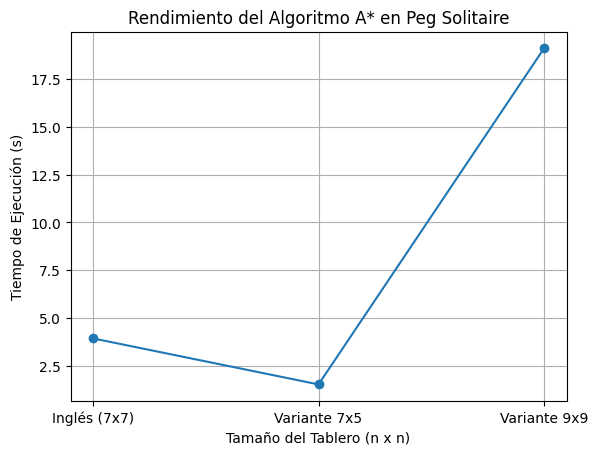

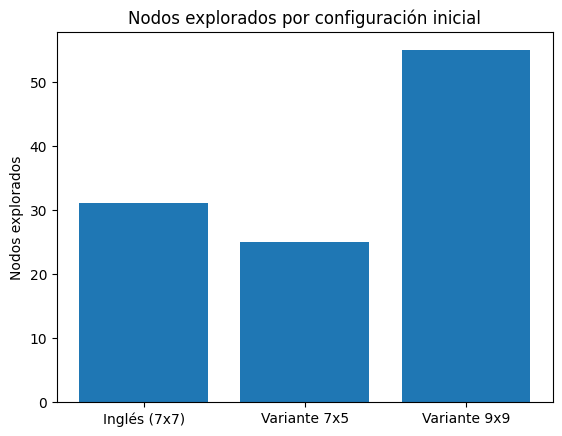

In [66]:
import matplotlib.pyplot as plt
def benchmark(configs):
    times, nodes = [], []
    for conf in configs:
        start_time = time.time()
        solution = solve_with_astar(conf, verbose=False)
        end_time = time.time()
        times.append(end_time - start_time)
        nodes.append(len(solution) if solution else 0)
    return times, nodes

# Ejemplo: tablero inglés y europeo (debes definir _default_european en tu Board)
configs = [Board(), Board(0), Board(1)]  # 7x7 y 7x5
names = ["Inglés (7x7)", "Variante 7x5", "Variante 9x9"]
times, nodes = benchmark(configs)
plt.plot(names, times, marker='o')
plt.title('Rendimiento del Algoritmo A* en Peg Solitaire')
plt.xlabel('Tamaño del Tablero (n x n)')
plt.ylabel('Tiempo de Ejecución (s)')
plt.xticks(names)
plt.grid()
plt.show()

# Gráfico de barras para nodos explorados
plt.bar(names, nodes)
plt.ylabel("Nodos explorados")
plt.title("Nodos explorados por configuración inicial")
plt.show()